In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


201 investors in 17-quarter 13F data:  
* instruments: 10972  


df_sub merge with RDC (COMNAME, industry info):
* 5 instru not in RDC
* instruments: 10972 - 5 = 10967  


merge with mkt cap data:
* 27 instru with no mkt cap at all
* 243 instru with no full mkt cap for 17 time points (including 27 above)
* instruments: 10928

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
# read in 13F results
file_name = '/content/gdrive/My Drive/capstone/full database/Results_20160630_20200630.csv'
df = pd.read_csv(file_name)
df['HOLDDATE'] = df['HOLDDATE'].str.replace(r' 00:00:00', '')

In [ ]:
n_investors = df.LGCYINVESTORID.nunique()
print('There are {} investors in 13F data.'.format(n_investors))

There are 6537 investors in 13F data.


In [ ]:
# read in list of investors of interest
# df_investors = pd.read_csv('/content/gdrive/My Drive/capstone/full database/active_investor_list.csv')
# df_investors = df_investors[df_investors.isActive==True]
# ls_investors = df_investors.LgcyInvestorId.to_list()

df_investors = pd.read_csv('/content/gdrive/MyDrive/capstone/full database/list_investors_225.csv')
ls_investors = df_investors.LGCYINVESTORID.to_list()

investor_name = pd.read_csv('/content/gdrive/MyDrive/capstone/full database/company_name.csv')
investor_name = investor_name.set_index('LGCYINVESTORID')
# print('There are {} investors which are we interested in.'.format(len(ls_investors)))

In [ ]:
# active_ls_investors = df_investors[df_investors.isActive==True]

In [ ]:
# get those in predefined list
df_sub = df.loc[df['LGCYINVESTORID'].isin(ls_investors),['INSTRID', 'COMNAME', 'LGCYINVESTORID', 'FULLNAME', 'HOLDDATE', 'SHSHLDVAL']]

# calculate the sum of SHSHLDVAL for each investor in each quarter
df_sub['SHSHLDVAL_Sum_ByQuarter'] = df_sub.groupby(['LGCYINVESTORID','HOLDDATE']).transform('sum').drop(['INSTRID', 'FULLNAME'], axis = 1)

# calculate the (13F only) pct of the SHSHLDVAL of each instrument in its investor's sum of SHSHLDVAL for each quarter 
# (i.e. revised version of 'PCTPORTFOLIO', so that sum up to 1)
df_sub['PCTPORTFOLIO_13F'] = df_sub['SHSHLDVAL'] / df_sub['SHSHLDVAL_Sum_ByQuarter']

In [ ]:
sum(df_sub.drop_duplicates(subset=['INSTRID','COMNAME']).COMNAME.isna())

5

In [ ]:
df_sub.drop_duplicates(subset=['INSTRID','COMNAME'])[df_sub.drop_duplicates(subset=['INSTRID','COMNAME']).COMNAME.isna()]

,INSTRID,COMNAME,LGCYINVESTORID,FULLNAME,HOLDDATE,SHSHLDVAL,SHSHLDVAL_Sum_ByQuarter,PCTPORTFOLIO_13F
17311989,18040214097,NaN,2003020,BofA Global Research (US),2019-03-31,38477.76,3.513862e+11,1.095028e-07
17434408,18040229076,NaN,2006452,Citadel Advisors LLC,2020-06-30,269235.57,6.344707e+10,4.243467e-06
17434833,18040229403,NaN,2002875,"American Century Investment Management, Inc.",2020-06-30,65729096.27,1.052599e+11,6.244455e-04
17435139,18040229077,NaN,2002715,Credit Suisse Securities (USA) LLC,2020-06-30,4998080.20,2.742758e+10,1.822283e-04
17435428,18040229670,NaN,2001935,"UBS Financial Services, Inc.",2020-06-30,7274.57,1.839275e+11,3.955128e-08


In [ ]:
sum(df_sub.drop_duplicates(subset=['INSTRID','COMNAME']).COMNAME.isna())/len(df_sub.drop_duplicates(subset=['INSTRID','COMNAME']))

0.0004540088985744121

In [ ]:
len(df_sub)

3737571

## Remove instruments not in RDC (i.e. NA in Comname)

In [ ]:
len(df_sub.loc[df_sub['COMNAME'].isna(),:]) # There are 13 rows with instruments not in RDC

36

In [ ]:
df_sub = df_sub.dropna()
len(df_sub)

3737535

In [ ]:
len(set(df_sub['INSTRID']))

11008

In [ ]:
vanguard_id = '2004260'

## Fill in missing time

In [ ]:
def fill_in_missing_date(df, dateColName, valColName):
  '''
  df: Column for investor id is 'LGCYINVESTORID' and column for instrumnet id is 'INSTRID'
  dateColName: Fill in all the dates starting from the earlist to latest mentioned in this column
  valColName: The column you want to fill in missing value.
              The missing value will be filled as 0.

  Return: a dataframe with filled missing value as 0 in valColName
  '''
  # create pivot table with id and date
  df_pivot = pd.pivot_table(df,index='LGCYINVESTORID', columns= dateColName, values=valColName)
  # fill in the missing value as 0. Each investor have data for all time stamp.
  df_pivot.fillna(0,inplace=True)

  # turn the pivot table to original format
  df_stack = df_pivot.stack().reset_index()
  df_stack.rename(columns = {0: valColName},inplace=True)
  # map back the original df
  df = pd.merge(df.drop(columns=valColName),df_stack,on = ['LGCYINVESTORID',dateColName])
  return df_stack


## Feature: Asset allocation


In [ ]:
asset_aloc = pd.read_csv('/content/gdrive/My Drive/capstone/full database/AssetAllocWithDesc.csv')

In [ ]:
asset_aloc[asset_aloc.LgcyInvestorId.isin(ls_investors)]

,LgcyInvestorId,FullName,AstAllocReg,AstAllocRegDesc,EqAstAlloc,EqAstAllocDesc,FIAstAlloc,FIAstAllocDesc,CashAstAlloc,CashAstAllocDesc,TotAstAlloc,TotAstAllocDesc
1,2004000,"Nomura Asset Management Co., Ltd.",AAREG5,Australasia Non-Domestic,AARANGE5,$200-499M,AARANGE6,$500-999M,AARANGE2,None ($0),AARANGE7,$1.0-2.4B
11,2455426,"Adage Capital Management, L.P.",AAREG7,Total Assets,AARANGE11,$20.0-49.9B,AARANGE1,Unknown,AARANGE1,Unknown,AARANGE11,$20.0-49.9B
36,2575182,SEI Investments Management Corporation,AAREG6,Other Non-Domestic,AARANGE2,None ($0),AARANGE2,None ($0),AARANGE2,None ($0),AARANGE2,None ($0)
104,2004351,"Charles Schwab Investment Management, Inc.",AAREG7,Total Assets,AARANGE14,Over $150B,AARANGE1,Unknown,AARANGE1,Unknown,AARANGE14,Over $150B
110,2003294,Invesco Canada Ltd.,AAREG7,Total Assets,AARANGE10,$10.0-19.9B,AARANGE1,Unknown,AARANGE1,Unknown,AARANGE11,$20.0-49.9B
...,...,...,...,...,...,...,...,...,...,...,...,...
6300,3318171,"BlueMountain Capital Management, LLC",AAREG7,Total Assets,AARANGE4,$25-199M,AARANGE1,Unknown,AARANGE1,Unknown,AARANGE10,$10.0-19.9B
6325,2906273,"Great Point Partners, LLC",AAREG7,Total Assets,AARANGE7,$1.0-2.4B,AARANGE1,Unknown,AARANGE1,Unknown,AARANGE8,$2.5-4.9B
6334,2507775,Balyasny Asset Management LP,AAREG7,Total Assets,AARANGE9,$5.0-9.9B,AARANGE1,Unknown,AARANGE1,Unknown,AARANGE13,$100-149.9B
6356,2002582,Victory Capital Management Inc.,AAREG7,Total Assets,AARANGE12,$50.0-99.9B,AARANGE1,Unknown,AARANGE1,Unknown,AARANGE14,Over $150B


In [ ]:
asset_aloc[asset_aloc.LgcyInvestorId.isin(ls_investors)]['TotAstAlloc'].value_counts(normalize=True)

AARANGE11    0.196429
AARANGE1     0.169643
AARANGE10    0.125000
AARANGE14    0.116071
AARANGE12    0.084821
AARANGE2     0.066964
AARANGE13    0.062500
AARANGE8     0.040179
AARANGE7     0.035714
AARANGE9     0.031250
AARANGE5     0.026786
AARANGE3     0.017857
AARANGE4     0.013393
AARANGE6     0.013393
Name: TotAstAlloc, dtype: float64

In [ ]:
asset_aloc['EqAstAlloc'].value_counts()

AARANGE4     1978
AARANGE5     1477
AARANGE6      794
AARANGE7      616
AARANGE3      412
AARANGE2      351
AARANGE8      307
AARANGE9      195
AARANGE10     131
AARANGE11     114
AARANGE12      52
AARANGE13      28
AARANGE14      24
AARANGE1       16
Name: EqAstAlloc, dtype: int64

In [ ]:
asset_aloc['TotAstAlloc'].value_counts(normalize=True)

AARANGE1     0.251819
AARANGE5     0.188825
AARANGE6     0.124284
AARANGE7     0.114998
AARANGE4     0.080328
AARANGE8     0.062839
AARANGE2     0.053243
AARANGE9     0.035289
AARANGE11    0.027859
AARANGE10    0.026157
AARANGE12    0.009751
AARANGE3     0.009441
AARANGE14    0.008822
AARANGE13    0.006346
Name: TotAstAlloc, dtype: float64

In [ ]:
asset_aloc[asset_aloc['TotAstAlloc'] == 'AARANGE1']

,LgcyInvestorId,FullName,AstAllocReg,AstAllocRegDesc,EqAstAlloc,EqAstAllocDesc,FIAstAlloc,FIAstAllocDesc,CashAstAlloc,CashAstAllocDesc,TotAstAlloc,TotAstAllocDesc
2,5928246,"Hunt Lane Capital Management, LLC",AAREG7,Total Assets,AARANGE5,$200-499M,AARANGE3,Under $25M,AARANGE1,Unknown,AARANGE1,Unknown
6,10264811,Citizens National Bank Trust Department,AAREG7,Total Assets,AARANGE5,$200-499M,AARANGE1,Unknown,AARANGE1,Unknown,AARANGE1,Unknown
9,2006029,Mandatum Henkivakuutusosakeyhtiö,AAREG7,Total Assets,AARANGE7,$1.0-2.4B,AARANGE1,Unknown,AARANGE1,Unknown,AARANGE1,Unknown
13,4974839,Fosun International Ltd,AAREG7,Total Assets,AARANGE9,$5.0-9.9B,AARANGE1,Unknown,AARANGE1,Unknown,AARANGE1,Unknown
18,2005462,Comgest S.A.,AAREG7,Total Assets,AARANGE11,$20.0-49.9B,AARANGE1,Unknown,AARANGE1,Unknown,AARANGE1,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...
6475,2004323,Gilder Gagnon Howe & Co. LLC,AAREG7,Total Assets,AARANGE10,$10.0-19.9B,AARANGE1,Unknown,AARANGE1,Unknown,AARANGE1,Unknown
6477,6310614,Bristol County Savings Bank,AAREG7,Total Assets,AARANGE4,$25-199M,AARANGE1,Unknown,AARANGE1,Unknown,AARANGE1,Unknown
6479,3726932,Turiya Advisors Asia Limited,AAREG7,Total Assets,AARANGE5,$200-499M,AARANGE1,Unknown,AARANGE1,Unknown,AARANGE1,Unknown
6481,5844179,Carve Capital AB,AAREG7,Total Assets,AARANGE4,$25-199M,AARANGE1,Unknown,AARANGE1,Unknown,AARANGE1,Unknown


In [ ]:
own2code = pd.read_excel('/content/gdrive/My Drive/capstone/full database/Own2Code.xlsx')

In [ ]:
own2code[own2code['Type_'] == 11]

,Type_,Code,Desc_
446,11,AAREG1,Domestic Assets
447,11,AAREG2,North America Non-Domestic
448,11,AAREG3,Europe Non-Domestic
449,11,AAREG4,Asia & Far East Non-Domestic
450,11,AAREG5,Australasia Non-Domestic
451,11,AAREG6,Other Non-Domestic
452,11,AAREG7,Total Assets


## Feature: pctportofolio with aggregated market cap

In [ ]:
mktcap = pd.read_csv('/content/gdrive/My Drive/capstone/full database/MktCap_MktCapSize_20160630_20200630.csv')
mktcap

,InstrId,EffectDate,PrcCloseAct,NumOfShOut,MktCap,MktCapSize
0,8589934595,2016-06-30,0.0200,29520523,5.904105e+05,NanoCap
1,8589934597,2016-06-30,18.5100,16347483,3.025919e+08,SmallCap
2,8589934599,2016-06-30,0.0700,40000000,2.800000e+06,NanoCap
3,8589934600,2016-06-30,1.2100,2750000,3.327500e+06,NanoCap
4,8589934603,2016-06-30,33.7200,50700002,1.709604e+09,SmallCap
...,...,...,...,...,...,...
1987028,8590939913,2020-06-30,0.0800,1168546867,9.348375e+07,MicroCap
1987029,8590939914,2020-06-30,9.9800,3512766,3.505740e+07,NanoCap
1987030,8590939915,2020-06-30,103.0400,135980227,1.401140e+10,LargeCap
1987031,8590939917,2020-06-30,0.0884,467734596,4.134774e+07,NanoCap


In [ ]:
# number of instruments not in mktcap data
len(set(df_sub['INSTRID']) - set(mktcap['InstrId']))

28

In [ ]:
merge = pd.merge(df_sub, mktcap, how='inner', left_on=['INSTRID', 'HOLDDATE'], right_on=['InstrId', 'EffectDate'])
merge.drop(columns=['InstrId', 'EffectDate'])

agg_mktcap_pivot = pd.pivot_table(merge,index = ['LGCYINVESTORID', 'HOLDDATE'], columns = ['MktCapSize'],values=['PCTPORTFOLIO_13F'],aggfunc=[np.sum],fill_value=0)

investor_set = set(agg_mktcap_pivot.index.get_level_values('LGCYINVESTORID'))
holddate_set = set(agg_mktcap_pivot.index.get_level_values('HOLDDATE'))

mktcap_cat = ['PctLargeCap', 'MegaCap', 'MicroCap', 'MidCap', 'NanoCap', 'SmallCap']

In [ ]:
# Number of isntruments with no mkt cap or no full 17 time points
# len(set(pd.merge(df_sub, mktcap, how='left', 
#                  left_on=['INSTRID', 'HOLDDATE'], 
#                  right_on=['InstrId', 'EffectDate']).loc[merge['InstrId'].isna(),:].INSTRID))

In [ ]:
len(set(merge['INSTRID']))

10968

In [ ]:
agg_mktcap_pivot.columns = mktcap_cat
agg_mktcap_pivot = agg_mktcap_pivot.reset_index()
for inv in investor_set:
  holddates = set(agg_mktcap_pivot[agg_mktcap_pivot['LGCYINVESTORID']==inv]['HOLDDATE'].to_list())
  if len(holddates) < len(holddate_set):
    # print('Investor ID:', inv, ' missing:')
    # print(holddate_set - holddates)
    missing_dates = holddate_set - holddates
    for md in missing_dates:
      agg_mktcap_pivot = agg_mktcap_pivot.append([{'LGCYINVESTORID': inv, 'HOLDDATE':md}])

agg_mktcap_pivot = agg_mktcap_pivot.fillna(0)     

In [ ]:
assert len(agg_mktcap_pivot) == len(investor_set) * len(holddate_set)

In [ ]:
agg_mktcap_pivot = agg_mktcap_pivot.set_index(['LGCYINVESTORID','HOLDDATE']).stack().reset_index()
agg_mktcap_pivot = agg_mktcap_pivot.rename(columns={agg_mktcap_pivot.columns[-2]:'MktCap',agg_mktcap_pivot.columns[-1]:'PCTPORTFOLIO_13F'})

In [ ]:
agg_mktcap_pivot = agg_mktcap_pivot.pivot_table(index=['LGCYINVESTORID'],columns=['HOLDDATE', 'MktCap'],values=['PCTPORTFOLIO_13F'])
agg_mktcap_pivot.columns =  agg_mktcap_pivot.columns.droplevel()

## Feature: Turnover

In [ ]:
# read in turnover rate
turnover = pd.read_csv('/content/gdrive/My Drive/capstone/full database/Own2InvHldTO.csv')
turnover['EffectToDate'] = turnover['EffectToDate'].str.replace(r' 00:00:00', '')

turnover = turnover[(turnover.IncWrntsCert == 1) & (turnover.CalcBasisCode==2)]

In [ ]:
# select these in a list
turnover = turnover[turnover.LgcyInvestorId.isin(ls_investors) ]

In [ ]:
# fill in 0 for missing date
turnover_pivot = turnover.pivot_table(index='LgcyInvestorId', columns='EffectToDate',values='OwnTurnover').fillna(0)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
# create distance matrix for gephi 
turnover_matrix = pd.DataFrame(euclidean_distances(turnover_pivot),index = turnover_pivot.index, columns=turnover_pivot.index)
# turnover_matrix.to_csv('/content/gdrive/My Drive/capstone/distance matrix/turnover_distance.csv')

## Feature: Top 20% pct

Definition: the porportion of investment on top 20% of instruments.
This represents the concentration of the investment. In other words, if this score is low, the investor prefers  distributed investment. Otherwise, the investor prefers concentrated investment.

### Create features for the listed investors

In [ ]:
def topPct(df, pct=0.2 ,k=10):
  n = len(df)
  k = int(pct * n)
  if k == 0:
    k = 1
  return sum(sorted(df)[-k:])/sum(df)

df_toppct = df_sub.groupby(['LGCYINVESTORID','FULLNAME','HOLDDATE']).agg({'SHSHLDVAL': topPct}).reset_index()

df_toppct.rename(columns={'SHSHLDVAL':'TOP20%SHSHLDVALpct'},inplace=True)

In [ ]:
df_toppct.LGCYINVESTORID.nunique()

225

In [ ]:
df_toppct = fill_in_missing_date(df_toppct, 'HOLDDATE', 'TOP20%SHSHLDVALpct')

In [ ]:
# df_toppct.to_csv('/content/gdrive/My Drive/capstone/full database/TOP20%SHSHLDVALpct_20160630_20200630.csv',index=False)

### Compute Euclidean distance

In [ ]:
concentration_pivot = df_toppct.pivot_table(index='LGCYINVESTORID', columns='HOLDDATE',values='TOP20%SHSHLDVALpct').fillna(0)

In [ ]:
# create distance matrix for listed investor
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
concentration_matrix = pd.DataFrame(euclidean_distances(concentration_pivot),index =concentration_pivot.index,columns=concentration_pivot.index)

In [ ]:
# concentration_matrix.to_csv('conventration_distance.csv')

## Feature: investment style, Industry, market of Investors' contacts

### Get description of different specialized code

We need to map with Own2Code(Type_=13) to get the description of the SpecCode.
SpecCat:
  - SpecCap == 1: Industry
    - Code in Own2Code: IS (201 different)
    - Code in data: xx
    - **Problem: IS193,IS194,IS195,IS196**
  - SpecCap == 3: Market Capitalization range in which the Investor Contact specializes
    - Code in Own2Code: MCS1 - MCS4
    - Code in data: 224 225 226 227
  - SpecCap == 4: Investment Style 
    - Code in Own2Code: ISS1 - ISS20(ISS19 not exists)
    - Code in data: 201 - 220 
    - **Problem: ISS19 not exists**

In [ ]:
# read in contacts info for investors in 13F
contact_info = '/content/gdrive/My Drive/capstone/full database/ContactResults.csv'
contact_df = pd.read_csv(contact_info)

In [ ]:
contact_df.head()

,LgcyInvestorId,LgcyPersonId,ContRole,ContRank,FirstName,LastName,Gender,SpecCat,SpecCode
0,2002008,9,Chief Investment Officer,1,Howard,Abner,M,1,95
1,2002008,9,Chief Investment Officer,1,Howard,Abner,M,4,202
2,2002008,9,Chief Investment Officer,1,Howard,Abner,M,4,208
3,2002008,9,Chief Investment Officer,1,Howard,Abner,M,4,216
4,2002008,9,Chief Investment Officer,1,Howard,Abner,M,4,217


In [ ]:
# read in code table
code_file_name = '/content/gdrive/My Drive/capstone/full database/Own2Code.xlsx'
code_df = pd.read_excel(code_file_name)
code_df = code_df.fillna('9999999')
spec_code_df = code_df[code_df.Type_ == 13]

In [ ]:
def explanation_spec(SpecCat, SpecCode):
  if pd.isna(SpecCat) or pd.isna(SpecCode):
    return 
  SpecCode = int(SpecCode)
  try:
    if SpecCat == 1:
      return 'Industry_' + spec_code_df[spec_code_df.Code == ('IS'+str(SpecCode))] ['Desc_'].values[0]
    elif SpecCat == 3:
      return 'Market_' + spec_code_df[spec_code_df.Code == ('MCS'+str(SpecCode-223))]['Desc_'].values[0]
    elif SpecCat == 4:
      return 'InvStyle_' + spec_code_df[spec_code_df.Code == ('ISS'+str(SpecCode-200))]['Desc_'].values[0]
  except:
    No_explanation.append((SpecCat, SpecCode))
    return 'No_explanation'

In [ ]:

No_explanation = []
contact_df['SpecDesc_'] = contact_df.apply(lambda x: explanation_spec(x.SpecCat, x.SpecCode), axis=1)

In [ ]:
# part of specCat don't have specDesc_
from collections import Counter
Counter(No_explanation)

Counter({(1, 193): 653,
         (1, 194): 15,
         (1, 195): 9,
         (1, 196): 273,
         (4, 219): 1195})

In [ ]:
# Remove those with no explanation
contact_df = contact_df[contact_df['SpecDesc_'] != 'No_explanation']

### Aggregate for each investor

In [ ]:
investor_style = pd.pivot_table(contact_df,index=['LgcyInvestorId'],columns=['SpecCat','SpecDesc_'], values=['LgcyPersonId'],aggfunc='count')
# investor_style.fillna(0,inplace=True)
investor_style.columns = investor_style.columns.droplevel()

In [ ]:
print('{}({}) investors in 13F have contact info.'.format(len(investor_style), len(investor_style)/n_investors))

6302(0.9640507878231604) investors in 13F have contact info.


In [ ]:
# contact_df.groupby(['LgcyInvestorId','SpecCat','SpecDesc_']).agg({'LgcyPersonId':'count'}).reset_index().to_csv('investstyle.csv')

### Create features for the listed investors

In [ ]:
investor_style_sub = investor_style[investor_style.index.isin(ls_investors)]

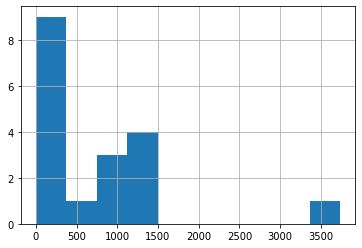

In [ ]:
# whether we need to do td-idf
investor_style_sub[4].sum(axis=0).hist()

In [ ]:
investor_style_sub[4].sum(axis=0).sort_values()

SpecDesc_
InvStyle_Technicals                  0.0
InvStyle_Private Equity             23.0
InvStyle_Quantitative               24.0
InvStyle_Growth                     29.0
InvStyle_Social Awareness           65.0
InvStyle_Sector Rotational          68.0
InvStyle_Venture Capital            89.0
InvStyle_Shareholder Activist      186.0
InvStyle_Special Situations        197.0
InvStyle_GARP                      733.0
InvStyle_Index                     930.0
InvStyle_Short Selling             986.0
InvStyle_Value                    1083.0
InvStyle_Arbitrage                1236.0
InvStyle_Income                   1239.0
InvStyle_Aggres. Gr.              1331.0
InvStyle_Convertible Arbitrage    1422.0
InvStyle_Emerging Markets         3737.0
dtype: float64

In [ ]:
# compute weight, use idf
industry_weight = np.log(len(investor_style_sub) / (investor_style_sub[1].count(axis=0) + 1))
invStyle_weight = np.log(len(investor_style_sub) / (investor_style_sub[4].count(axis=0) + 1))

In [ ]:
# normalize
def normalize(df):
  return df.div(df.sum(axis=1),axis=0).fillna(0)

industry_sub = normalize(investor_style_sub[1])
invStyle_sub = normalize(investor_style_sub[4])

In [ ]:
industry_sub

SpecDesc_,Industry_Aerospace/Defense,Industry_Agricultural Products,Industry_Air Freight,Industry_Airlines,Industry_Aluminum,Industry_Auto Parts & Equipment,Industry_Automobiles,Industry_Autos/Auto Parts,Industry_Banks & Thrifts,Industry_Banks (Major Regional),Industry_Banks (Money Center),Industry_Banks (Regional),Industry_Beverages (Alcoholic),Industry_Beverages (Non-Alcoholic),Industry_Biofuels,Industry_Biotechnology,"Industry_Broadcasting (TV,Radio,Ca",Industry_Building Materials,Industry_Business Cyclicals,Industry_Business Staples,Industry_Cellular/Wireless Telecom,Industry_Chemicals,Industry_Clean technology,Industry_Communication Services,Industry_Communications Equipment,Industry_Computer Hardware,Industry_Computer Services,Industry_Computer Software,Industry_Computers (Networking),Industry_Computers (Peripherals),Industry_Consumer (Jewelry/Novelti,Industry_Consumer Cyclicals,Industry_Consumer Discretionary,Industry_Consumer Electronics,Industry_Consumer Finance,Industry_Consumer Staples,Industry_Containers-Metal & Glass,Industry_Containers/Packaging (Pap,Industry_Distributors (Durables),Industry_Distributors (Food & Heal,...,Industry_Renewable Energy,Industry_Restaurants,Industry_Retail,Industry_Retail (Building Supplies,Industry_Retail (Computers/Electro,Industry_Retail (Discounters/Offpr,Industry_Retail (Footwear),Industry_Retail (Home Items),Industry_Retail (Home Shopping/Cat,Industry_Retail Specialty-Apparel,Industry_Retail Stores-Dept Stores,Industry_Retail Stores-Drug Store,Industry_Retail Stores-Food Chains,Industry_Retail Stores-Gen Mer Cha,Industry_Retail-Specialty,Industry_Savings & Loan Companies,Industry_Semiconductors,Industry_Services (Advertising/Mkt,Industry_Services (Commercial Cons,Industry_Services (Employment),Industry_Services (Facils/Enviromn,Industry_Services (Payroll Process,Industry_Services (Rentals),Industry_Shipping,Industry_Specialty Communications,Industry_Steel,Industry_Technology,Industry_Telecommunication Service,Industry_Telephone (Local),Industry_Telephone-Local,Industry_Telephone-Long Distance,Industry_Textiles,Industry_Tobacco,Industry_Transportation,Industry_Truckers,Industry_Trucks & Parts,Industry_Utilities,Industry_Waste Management,Industry_Water Technology,Industry_Water Utilities
LgcyInvestorId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000264,0.018692,0.037383,0.0,0.0,0.000000,0.009346,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037383,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.00000,0.037383,0.000000,0.000000,0.037383,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.028037,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.00000,0.000000,0.028037,0.0,0.037383,0.252336,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000,0.018692,0.000000,0.000000,0.0,0.037383,0.000000,0.0,0.000000,0.000000
2001934,0.016563,0.016563,0.0,0.0,0.000000,0.006211,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.018634,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.006211,0.004141,0.0,0.00,0.00000,0.016563,0.000000,0.000000,0.018634,0.0,0.000000,0.004141,0.0,0.000000,0.000000,0.006211,0.006211,0.000000,0.000000,0.0,...,0.0,0.018634,0.000000,0.0,0.008282,0.000000,0.000000,0.00207,0.000000,0.008282,0.0,0.018634,0.320911,0.004141,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00207,0.000000,0.0,0.000000,0.016563,0.000000,0.000000,0.0,0.018634,0.008282,0.0,0.002070,0.000000
2001935,0.009174,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.009174,0.000000,0.000000,0.0,...,0.0,0.009174,0.000000,0.0,0.000000,0.000

In [ ]:
# compute distance 
invStyle_matrix = pd.DataFrame(euclidean_distances(industry_sub),index =industry_sub.index,columns=industry_sub.index)

In [ ]:
# invStyle_matrix.to_csv('invStyle_distance.csv')

## Feature: Number of instruments

In [ ]:
n_instruments = df_sub.groupby(['LGCYINVESTORID','HOLDDATE']).agg({'INSTRID':'count'}).reset_index()
n_instruments_pivot = pd.pivot_table(n_instruments,index=['LGCYINVESTORID'],columns=['HOLDDATE'],values=['INSTRID']).fillna(0)

In [ ]:
n_instruments_pivot.columns = n_instruments_pivot.columns.droplevel()

In [ ]:
n_instruments_pivot_static = n_instruments.groupby('LGCYINVESTORID').agg({'INSTRID':'max'})

## Feature: Total Asset

In [ ]:

total_asset = df_sub.groupby(['LGCYINVESTORID','HOLDDATE']).agg({'SHSHLDVAL_Sum_ByQuarter':'max'}).reset_index()
n_instruments_pivot = pd.pivot_table(df_sub,index=['LGCYINVESTORID'],columns=['SHSHLDVAL_Sum_ByQuarter'],values=['INSTRID']).fillna(0)

In [ ]:
total_asset = df_sub.groupby(['LGCYINVESTORID','HOLDDATE']).agg({'SHSHLDVAL_Sum_ByQuarter':'max'}).reset_index()
total_asset_pivot = pd.pivot_table(total_asset,index=['LGCYINVESTORID'],columns=['HOLDDATE'],values=['SHSHLDVAL_Sum_ByQuarter']).fillna(0)

In [ ]:
total_asset_pivot.columns = total_asset_pivot.columns.droplevel()

In [ ]:
total_asset_pivot_static = total_asset.groupby('LGCYINVESTORID').agg({'SHSHLDVAL_Sum_ByQuarter':'max'})

## Feature: pctportofolio with aggregated **Industry**

In [ ]:
df_industry_raw = pd.read_csv('/content/gdrive/My Drive/capstone/full database/portfolio_with_industry.csv')

In [ ]:

# df_industry_raw.loc[((df_industry_raw['LGCYINVESTORID']==2578454) & (df_industry_raw['INSTRID']==8589934707)), :]

In [ ]:
df_industry = df_industry_raw.copy()
df_industry = df_industry[['INSTRID', 'HOLDDATE', 'EndDate', 'HierarchicalId', 'Title']]
df_industry = df_industry.drop_duplicates()

In [ ]:
df_industry['HOLDDATE'] = df_industry['HOLDDATE'].str.replace(r' 00:00:00', '')
df_industry['EndDate'] = df_industry['EndDate'].str.replace(r' 00:00:00.000', '')

# df_industry['HOLDDATE'] = pd.to_datetime(df_industry['HOLDDATE'], format='%Y-%m-%d')
# df_industry['EndDate'] = pd.to_datetime(df_industry['EndDate'], format='%Y-%m-%d')

In [ ]:
df_industry['EndDate'].fillna('2020-11-11', inplace=True)

In [ ]:
print(len(set(df_industry.loc[df_industry['EndDate'] == '2020-11-11',:].INSTRID)))
df_industry_latest = df_industry.loc[df_industry['EndDate'] == '2020-11-11',:].dropna()
len(set(df_industry_latest.INSTRID))

10018


8547

In [ ]:
df_industry_latest['HierarchicalId'] = df_industry_latest['HierarchicalId'].astype(str).str[0:4]

In [ ]:
len(set(df_industry_latest.HierarchicalId))

30

In [ ]:
industry_merge = pd.merge(df_sub, df_industry_latest, how='inner', on=['INSTRID', 'HOLDDATE'])[['LGCYINVESTORID','HOLDDATE','PCTPORTFOLIO_13F','HierarchicalId']]

agg_industry_pivot = pd.pivot_table(industry_merge,index = ['LGCYINVESTORID', 'HOLDDATE'], columns = ['HierarchicalId'],values=['PCTPORTFOLIO_13F'],aggfunc=[np.sum],fill_value=0)

ind_investor_set = set(agg_industry_pivot.index.get_level_values('LGCYINVESTORID'))
ind_holddate_set = set(agg_industry_pivot.index.get_level_values('HOLDDATE'))

In [ ]:
len(set(industry_merge['LGCYINVESTORID']))

225

In [ ]:
# fill industry pct of any missing date with 0

industry_id_list = [HierarchicalId for (_,_,HierarchicalId) in list(agg_industry_pivot.columns)]

agg_industry_pivot.columns = industry_id_list
agg_industry_pivot = agg_industry_pivot.reset_index()
for inv in ind_investor_set:
  holddates = set(agg_industry_pivot[agg_industry_pivot['LGCYINVESTORID']==inv]['HOLDDATE'].to_list())
  if len(holddates) < len(ind_holddate_set):
    missing_dates = holddate_set - holddates
    for md in missing_dates:
      agg_industry_pivot = agg_industry_pivot.append([{'LGCYINVESTORID': inv, 'HOLDDATE':md}])

agg_industry_pivot = agg_industry_pivot.fillna(0)

In [ ]:
agg_industry_pivot = agg_industry_pivot.set_index(['LGCYINVESTORID','HOLDDATE']).stack().reset_index()
agg_industry_pivot = agg_industry_pivot.rename(columns={agg_industry_pivot.columns[-2]:'Industry',agg_industry_pivot.columns[-1]:'PCTPORTFOLIO_13F'})

agg_industry_pivot = agg_industry_pivot.pivot_table(index=['LGCYINVESTORID'],columns=['HOLDDATE', 'Industry'],values=['PCTPORTFOLIO_13F'])
agg_industry_pivot.columns =  agg_industry_pivot.columns.droplevel()

## K_means

In [ ]:
# normalize turnover_pivot
max_turnover = turnover_pivot.max().max()
turnover_pivot_standard = turnover_pivot/max_turnover

In [ ]:
# normalize number of instruments
max_n_instruments = n_instruments_pivot_static.max()
# n_instruments_pivot_standard = n_instruments_pivot/max_n_instruments
n_instruments_pivot_static_standard = n_instruments_pivot_static/max_n_instruments

In [ ]:
# normalize total asset
max_total_asset = total_asset_pivot.max().max()
total_asset_pivot_standard = total_asset_pivot/max_total_asset
total_asset_pivot_static_standard = total_asset_pivot_static/max_total_asset

In [ ]:


X = pd.concat([agg_mktcap_pivot,
               agg_industry_pivot,
               turnover_pivot_standard, 
               n_instruments_pivot_static_standard,
               total_asset_pivot_static_standard,
               concentration_pivot,
               invStyle_sub], axis=1).fillna(0)


# X = agg_mktcap_pivot
X_sub = X
# X_sub = X[X.index.isin(active_ls_investors.LgcyInvestorId)]

# # select mutual fund
# mutual_fund = pd.read_csv('/content/Mutual Funds.csv',header=None)
# hedge_fund = pd.read_csv('/content/Hedge Funds.csv',header=None)
# X_sub = X_sub[X_sub.index.isin(hedge_fund[0])]

In [ ]:
# set(mutual_fund[0]) & set(hedge_fund[0])

In [ ]:
# standardization

from sklearn import preprocessing
# Get column names first
names = X_sub.columns
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
scaled_df = scaler.fit_transform(X_sub)
scaled_df = pd.DataFrame(scaled_df, columns=names)

In [ ]:
from sklearn.cluster import KMeans

def fit_kmeans(n_components,X):
    km = KMeans(n_components)
    km.fit(X)
    predictions = km.predict(X)
    return predictions

In [ ]:
from sklearn import metrics
from sklearn.cluster import SpectralClustering

def InternalEvaluation(data, clusters):
    scores = {}
    """
    The score is bounded between -1 for incorrect clustering and +1 for highly dense clustering. 
    Scores around zero indicate overlapping clusters.
    The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.
    """
    scores['_silhouette_score'] =metrics.silhouette_score(data,clusters ,metric='euclidean')
    """
    The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.
    The score is fast to compute
    """
    scores['_calinski_harabaz_score'] = metrics.calinski_harabasz_score(data,clusters)
    """
    Zero is the lowest possible score. Values closer to zero indicate a better partition.
    The Davies-Boulding index is generally higher for convex clusters than other concepts of clusters, 
    such as density based clusters like those obtained from DBSCAN.
    """
    scores['_davies_bouldin_score'] = metrics.davies_bouldin_score(data,clusters)
    return scores

def draw_scores(scores, start_k=2):
  score_type = list(scores[0].keys())
  n_type = len(score_type)
  plt.figure(figsize=(8,4))
  for i in range(n_type):
    sc_type = score_type[i]
    score = [sc[sc_type] for sc in scores]
    plt.subplot(1, n_type, i+1)
    plt.plot(range(start_k,len(score) + start_k ), score)
    plt.title(' '.join(sc_type.split('_')).title())
    plt.xlabel('k')
  plt.suptitle('Metrics for Clustering')

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def draw_tsne(X, predictions=None):
    tsne = TSNE(n_components=2)
    x = tsne.fit_transform(X)
    if predictions is None:
      plt.scatter(x[:,0],x[:,1])
      plt.title('tsne visualization')
    else:
      plt.scatter(x[:,0],x[:,1],c=predictions)
      plt.title('tsne visualization')

def draw_pca(X,predictions):
  pca = PCA(n_components=2)
  x = pca.fit_transform(X)
  plt.scatter(x[:,0],x[:,1],c=predictions)
  plt.title('pca visualization')


In [ ]:
def modeling(X):
  scores = []
  for k in range(2, 10):
    predictions = fit_kmeans(k,X)
    score = InternalEvaluation(X, predictions)
    scores.append(score)
  plt.figure(1)
  draw_scores(scores)
  plt.figure(2)
  # draw_tsne(X)

### original X_sub

In [ ]:
# compute the distance

from sklearn.metrics.pairwise import euclidean_distances

distance = pd.DataFrame(euclidean_distances(X_sub), index = X_sub.index, columns = X_sub.index)
result = distance.loc[int(vanguard_id),:].argsort()
ordered = pd.DataFrame(distance.loc[int(vanguard_id),:].iloc[result])

ordered_all = ordered
ordered_all.columns = ['all']

In [ ]:
i = 0
for df in [agg_mktcap_pivot,
               agg_industry_pivot,
               turnover_pivot_standard, 
               n_instruments_pivot_static_standard,
               total_asset_pivot_static_standard,
               concentration_pivot,
               invStyle_sub]:
  i += 1
  distance = pd.DataFrame(euclidean_distances(df), index = df.index, columns = df.index)
  result = distance.loc[int(vanguard_id),:].argsort()
  ordered = pd.DataFrame(distance.loc[int(vanguard_id),:].iloc[result])
  ordered_all[i] = ordered

In [ ]:
ordered_all.columns = ['all', 
                       'agg_by_mktcap',
                       'agg_by_industry', 
                       'turnover', 
                       'n_intruments',
                       'total_asset',
                       'concentration',
                       'invStyle']
ordered_all['Fullname'] = investor_name['FULLNAME']                       
ordered_all.to_csv('distance_to_vangard.csv')

<Figure size 432x288 with 0 Axes>

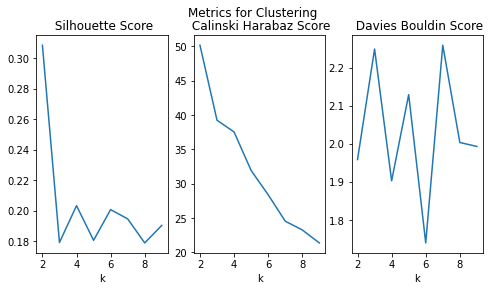

In [ ]:
# modeling 
X_result = investor_name[investor_name.index.isin(ls_investors)]


modeling(X_sub)

In [ ]:
df_result_report = pd.read_csv('/content/result_with_features (1).csv', index_col=0)

In [ ]:
predictions = df_result_report['kmeans_2']

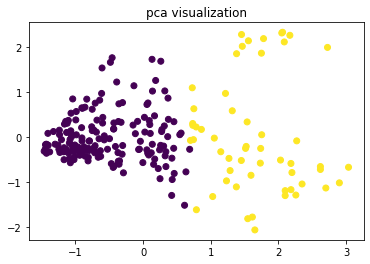

In [ ]:
draw_pca(X_sub, predictions)

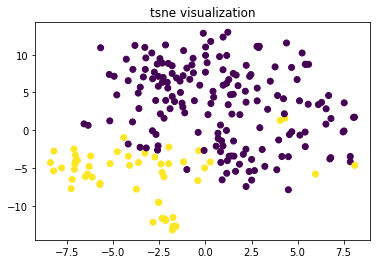

In [ ]:
draw_tsne(X_sub,predictions)

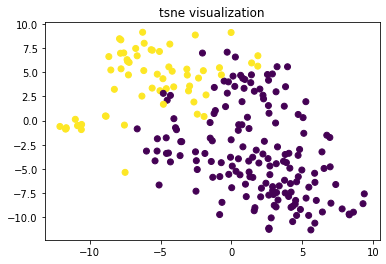

In [ ]:
predictions = fit_kmeans(2,X_sub)
draw_tsne(X_sub,predictions)

Text(0.5, 1.0, 'tsne visualization')

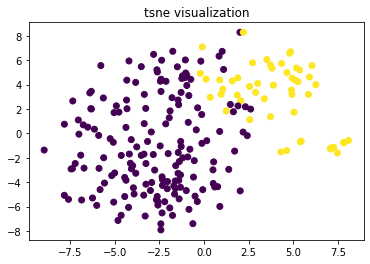

In [ ]:
p = 40
tsne = TSNE(n_components=2,perplexity = p)
x = tsne.fit_transform(X_sub)

plt.scatter(x[:,0],x[:,1],c=predictions)
plt.title('tsne visualization')

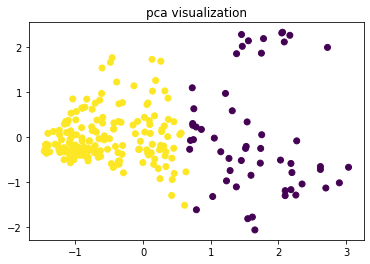

In [ ]:
predictions = fit_kmeans(2,X_sub)
draw_pca(X_sub,predictions)

In [ ]:
X_result['kmeans_2'] = pd.DataFrame(predictions, index = X_sub.index)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
X_result.to_csv('result.csv')

In [ ]:
X_result.loc[2004260]

FULLNAME    The Vanguard Group, Inc.
kmeans_2                           0
Name: 2004260, dtype: object

In [ ]:
X_result.loc[2502059]

FULLNAME    MKP Capital Management, L.L.C.
kmeans_2                                 0
Name: 2502059, dtype: object

In [ ]:
# company_name = pd.read_csv('company_name.csv')
# company_name = company_name.set_index('LGCYINVESTORID')
# X_result['FULLNAME'] = company_name

In [ ]:
pd.concat([X_result,X_sub],axis=1).to_csv('result_with_features.csv')

### static time

In [ ]:
concentration_pivot.columns

Index(['2016-06-30', '2016-09-30', '2016-12-31', '2017-03-31', '2017-06-30',
       '2017-09-30', '2017-12-31', '2018-03-31', '2018-06-30', '2018-09-30',
       '2018-12-31', '2019-03-31', '2019-06-30', '2019-09-30', '2019-12-31',
       '2020-03-31', '2020-06-30'],
      dtype='object', name='HOLDDATE')

In [ ]:
time = '2020-06-30'
X_static = pd.concat([agg_mktcap_pivot[time],
               agg_industry_pivot[time],
               turnover_pivot_standard[time], 
               n_instruments_pivot_static_standard,
               total_asset_pivot_static_standard,
               concentration_pivot[time],
               invStyle_sub['InvStyle_Emerging Markets']], axis=1).fillna(0)



<Figure size 432x288 with 0 Axes>

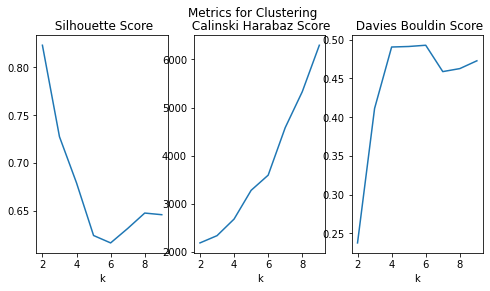

In [ ]:
modeling(pd.DataFrame(invStyle_sub['InvStyle_Emerging Markets']))

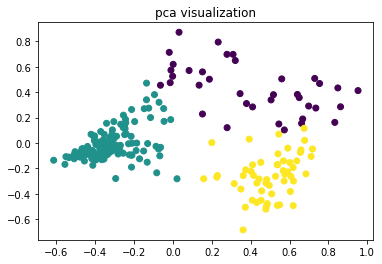

In [ ]:
predictions = fit_kmeans(3,X_static)
draw_pca(X_static,predictions)

In [ ]:
X_result['kmeans_2_static_2020Q2'] = 1- pd.DataFrame(predictions, index = X_sub.index)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
X_result.to_csv('kmeans_result.csv')

### standization normalize

<Figure size 432x288 with 0 Axes>

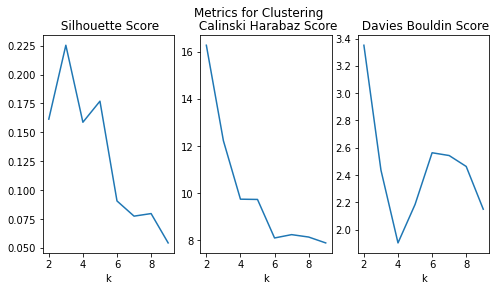

In [ ]:
modeling(scaled_df)

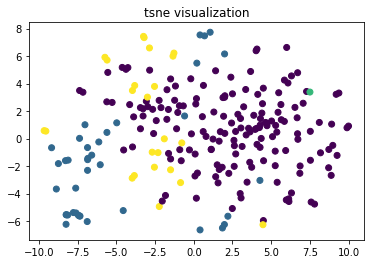

In [ ]:
predictions = fit_kmeans(4,scaled_df)
draw_tsne(scaled_df,predictions)

### PCA with original

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 20)
X_pca = pca.fit_transform(X_sub)

In [ ]:
sum(pca.explained_variance_ratio_)

0.8077246974184609

In [ ]:
sum(pca.explained_variance_ratio_[:2])

0.37616975228670363

In [ ]:
pca.components_[0][abs(pca.components_[0]).argsort()[-10:]]

array([-0.14308381, -0.14674326, -0.15557349, -0.15579048, -0.17201342,
       -0.17537782, -0.17653887, -0.1815138 , -0.18689925, -0.19254703])

In [ ]:
names[abs(pca.components_[0]).argsort()[-10:]]

Index([('2018-09-30', 'PctLargeCap'), ('2018-06-30', 'PctLargeCap'),
       ('2017-12-31', 'PctLargeCap'), ('2018-03-31', 'PctLargeCap'),
       ('2017-09-30', 'PctLargeCap'), ('2017-03-31', 'PctLargeCap'),
       ('2017-06-30', 'PctLargeCap'), ('2016-12-31', 'PctLargeCap'),
       ('2016-09-30', 'PctLargeCap'), ('2016-06-30', 'PctLargeCap')],
      dtype='object')

In [ ]:
abs(pca.components_[1]).argsort()[-10:]

array([636, 638, 639, 637, 634, 633, 632, 635, 630, 631])

In [ ]:
names[647]

'InvStyle_Aggres. Gr.'

In [ ]:
# concentration_pivot
names[abs(pca.components_[1]).argsort()[-10:]]

Index(['2017-12-31', '2018-06-30', '2018-09-30', '2018-03-31', '2017-06-30',
       '2017-03-31', '2016-12-31', '2017-09-30', '2016-06-30', '2016-09-30'],
      dtype='object')

In [ ]:
abs(pca.components_[2]).argsort()[-10:]

array([646,  28, 645,  22,  46,  58,  52,  34,  40, 650])

In [ ]:
# concentration & large cap
names[abs(pca.components_[2]).argsort()[-10:]]

Index([                 '2020-06-30', ('2017-06-30', 'PctLargeCap'),
                        '2020-03-31', ('2017-03-31', 'PctLargeCap'),
       ('2018-03-31', 'PctLargeCap'), ('2018-09-30', 'PctLargeCap'),
       ('2018-06-30', 'PctLargeCap'), ('2017-09-30', 'PctLargeCap'),
       ('2017-12-31', 'PctLargeCap'),   'InvStyle_Emerging Markets'],
      dtype='object')

In [ ]:
# 
names[abs(pca.components_[3]).argsort()[-10:]]

Index([       ('2017-12-31', '5510'),        ('2019-09-30', '5510'),
              ('2019-12-31', '5510'),        ('2020-03-31', '5510'),
       ('2019-06-30', 'PctLargeCap'), ('2020-03-31', 'PctLargeCap'),
       ('2019-03-31', 'PctLargeCap'), ('2020-06-30', 'PctLargeCap'),
       ('2019-09-30', 'PctLargeCap'), ('2019-12-31', 'PctLargeCap')],
      dtype='object')

Max: \\
'5420' stands for industry: Personal and household products and services \\
'5430' stands for industry: Food and drug retailing 4294952880 5430

Min: \\
'5220' stands for industry: Industrial and commercial services \\

In [ ]:
abs(pca.components_[1]).argsort()[-10:]

array([636, 638, 639, 637, 634, 633, 632, 635, 630, 631])

In [ ]:
names[abs(pca.components_[1]).argsort()[-10:]]

Index(['2017-12-31', '2018-06-30', '2018-09-30', '2018-03-31', '2017-06-30',
       '2017-03-31', '2016-12-31', '2017-09-30', '2016-06-30', '2016-09-30'],
      dtype='object')

Most important: \\
'5420' stands for industry: Personal and household products and services \\
'5220' stands for industry: Industrial and commercial services \\

<Figure size 432x288 with 0 Axes>

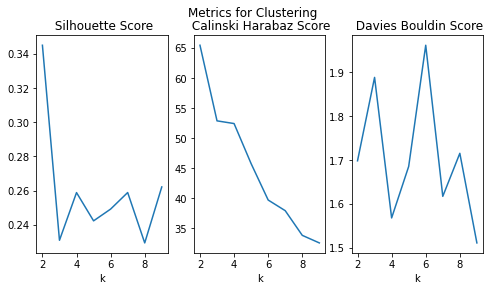

In [ ]:
modeling(X_pca)

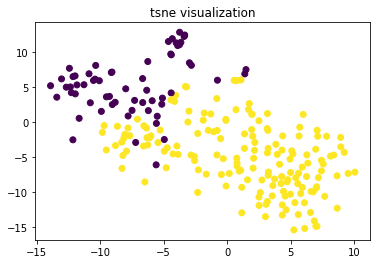

In [ ]:
predictions = fit_kmeans(2,X_pca)
draw_tsne(X_pca,predictions)

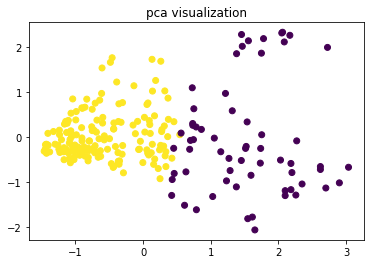

In [ ]:
draw_pca(X_pca,predictions)

In [ ]:
X_result.to_csv('results.csv')

In [ ]:
# [agg_mktcap_pivot,
#                agg_industry_pivot,
#                turnover_pivot_standard, 
#                n_instruments_pivot_static_standard,
#                total_asset_pivot_static_standard,
#                concentration_pivot,
#                invStyle_sub]


### other model

<Figure size 432x288 with 0 Axes>

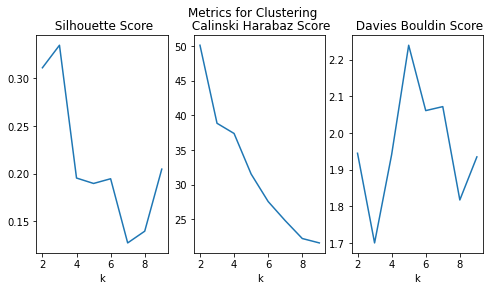

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.cluster import *

scores = []
for n_components in range(2, 10):
  GMM = GaussianMixture(n_components)
  GMM.fit(X_sub)
  predictions = GMM.predict(X_sub)
  score = InternalEvaluation(X_sub, predictions)
  scores.append(score)
plt.figure(1)
draw_scores(scores)


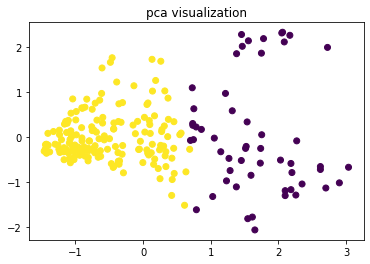

In [ ]:
GMM = GaussianMixture(2)
GMM.fit(X_sub)
predictions = GMM.predict(X_sub)
draw_pca(X_sub,predictions)

<Figure size 432x288 with 0 Axes>

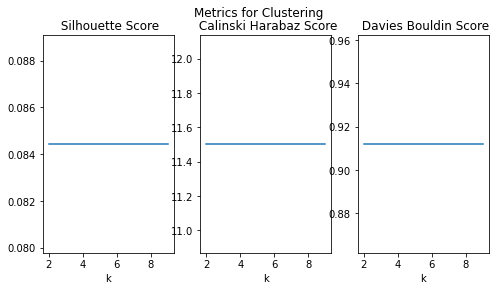

In [ ]:

scores = []
for n_components in range(2, 10):
  clustering = AffinityPropagation()
  clustering.fit(X_sub)
  predictions = clustering.labels_
  score = InternalEvaluation(X_sub, predictions)
  scores.append(score)
plt.figure(1)
draw_scores(scores)

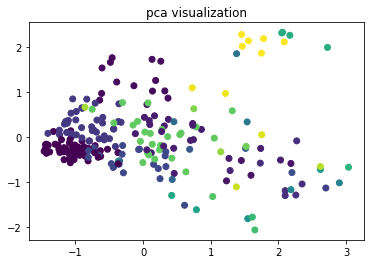

In [ ]:
clustering = AffinityPropagation()
clustering.fit(X_sub)
predictions = clustering.labels_
draw_pca(X_sub,predictions)

<Figure size 432x288 with 0 Axes>

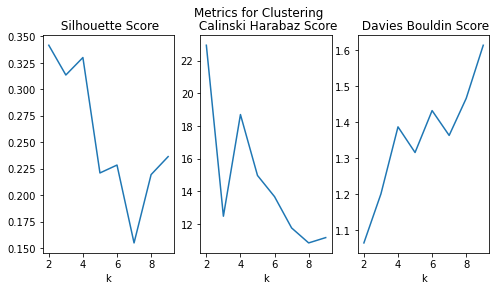

In [ ]:

scores = []
for n_components in range(2, 10):
  clustering = SpectralClustering(n_components)
  clustering.fit(X_sub)
  predictions = clustering.labels_
  score = InternalEvaluation(X_sub, predictions)
  scores.append(score)
plt.figure(1)
draw_scores(scores)

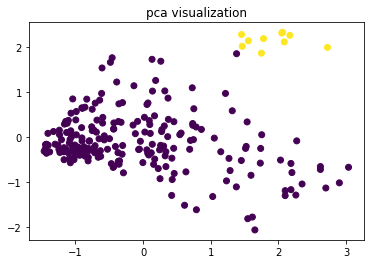

In [ ]:
clustering = SpectralClustering(2)
clustering.fit(X_sub)
predictions = clustering.labels_
draw_pca(X_sub,predictions)

<Figure size 432x288 with 0 Axes>

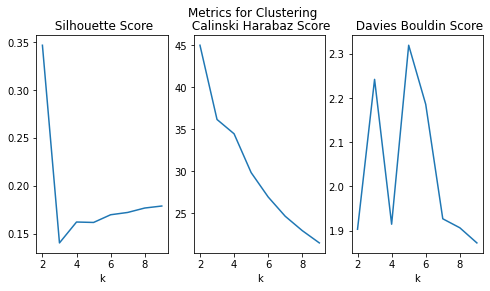

In [ ]:
scores = []
for n_components in range(2, 10):
  clustering = AgglomerativeClustering(n_components)
  clustering.fit(X_sub)
  predictions = clustering.labels_
  score = InternalEvaluation(X_sub, predictions)
  scores.append(score)
plt.figure(1)
draw_scores(scores)

In [ ]:
predictions

array([0, 5, 5, 0, 5, 5, 0, 1, 5, 3, 0, 5, 5, 3, 1, 1, 0, 5, 1, 5, 5, 5,
       0, 5, 5, 5, 0, 5, 0, 5, 5, 5, 5, 1, 5, 0, 5, 5, 5, 5, 5, 5, 0, 5,
       5, 5, 5, 5, 5, 3, 0, 0, 5, 5, 5, 3, 5, 5, 5, 1, 0, 5, 5, 5, 0, 5,
       5, 5, 5, 5, 5, 5, 5, 7, 5, 5, 5, 5, 5, 5, 0, 5, 5, 5, 0, 5, 0, 5,
       1, 8, 1, 5, 1, 3, 1, 1, 5, 1, 1, 1, 3, 5, 0, 5, 1, 1, 0, 1, 5, 2,
       5, 1, 0, 1, 0, 3, 1, 0, 3, 0, 1, 0, 0, 0, 3, 0, 5, 1, 2, 5, 0, 0,
       0, 4, 5, 1, 0, 5, 1, 5, 1, 0, 4, 1, 0, 1, 0, 2, 0, 5, 0, 5, 3, 8,
       2, 3, 5, 1, 5, 3, 1, 1, 1, 5, 5, 1, 5, 3, 3, 1, 5, 1, 7, 5, 0, 2,
       3, 6, 3, 0, 3, 3, 1, 0, 0, 7, 1, 0, 5, 3, 3, 1, 7, 0, 7, 3, 1, 0,
       3, 4, 3, 5, 5, 1, 0, 5, 7, 2, 0, 8, 1, 1, 0, 0, 2, 0, 5, 4, 4, 4,
       0, 7, 7, 7, 7])

### without portfolio data

In [ ]:
X_other = pd.concat([
               turnover_pivot_standard, 
               n_instruments_pivot_static_standard,
               total_asset_pivot_static_standard,
               concentration_pivot,
               invStyle_sub], axis=1).fillna(0)


<Figure size 432x288 with 0 Axes>

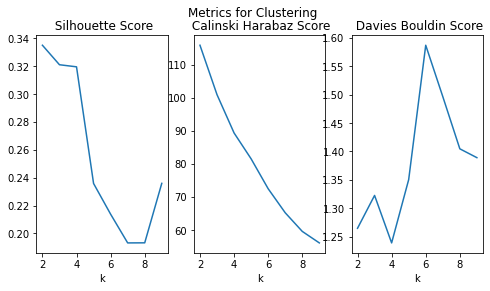

In [ ]:
modeling(X_other)

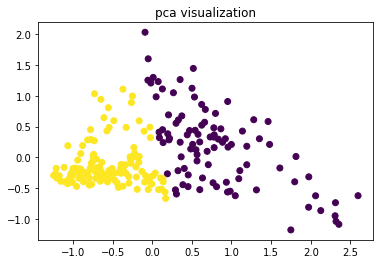

In [ ]:
predictions = fit_kmeans(2,X_other)
draw_pca(X_other, predictions)

In [ ]:

# result = pd.DataFrame({
#     'investor': X_sub.index,
#     'cluster': predictions
# })

In [ ]:
# # output the clustering result and merge with investor names and save to drive
# result_merge = pd.merge(df_sub, result, how='right', left_on=['LGCYINVESTORID'], right_on=['investor'])[['FULLNAME','LGCYINVESTORID','cluster']].drop_duplicates()
# result_merge.to_csv('/content/gdrive/My Drive/capstone/distance matrix/all_cluster_result.csv')